In [435]:
import os
import copy

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from IPython.display import display

from utils.constants import *

In [436]:
def summarize_restarts(orig_df, groupby_cols=['source_state', 'target_state'], max_restarts=5):
    df = copy.deepcopy(orig_df)
    df = df[df.iter < max_restarts]
    groups = df.groupby(groupby_cols).size().reset_index().rename(columns={0: 'count'})
    groups = groups.loc[groups['count'] > 0, :]
    rows = []
    for group in groups.values.tolist():
        group = group[:len(groupby_cols)]  # Isolate groupby
        query = []
        for i in range(len(group)):
            if isinstance(group[i], str):
                query.append(f"({groupby_cols[i]}.str.strip() == '{group[i]}')")
            else:
                query.append(f"({groupby_cols[i]} == {group[i]})")
        query = ' & '.join(query)
        df_i = df[df.eval(query)]
        row = group
        means = df_i[metric_cols].mean(0).values.tolist()
        stds = [0. if np.isnan(i) else i for i in df_i[metric_cols].std(0).values.tolist()]
        row += ['{:.3f} ({:.3f})'.format(mean, std) for mean, std in zip(means, stds)]
        row += [df_i.shape[0]]
        rows.append(row)
    cols = groupby_cols + metric_cols + ['num_restarts']
    out_df = pd.DataFrame(data=rows, columns=cols)
    return out_df

In [437]:
def print_df(df, metric_prefix='target'):
    pairs = list(set([tuple(i) for i in df[['source_state', 'target_state']].values.tolist()]))
    pairs = [('IL', 'IL')] + sorted([pair for pair in pairs if pair != ('IL', 'IL')])
    color_dict = {f'{metric_prefix}_acc': 'green', f'{metric_prefix}_auc': 'blue', f'{metric_prefix}_loss': 'purple'}
    df_color = df.style.apply(lambda x: ['background: {}'.format(color_dict[x.name]) if x.name in color_dict.keys() else '' for i in x])
    display(df_color)

In [438]:
def get_attr_val_from_dirname_combined(d):
    """Parses attributes from experiment directory name."""
    def get_attr(s):
        """Returns the value associated with the attribute."""
        return s.split('-')[-1]

    split_dir = d.split('_')
    ret_dict = {}
    ret_dict['exp_dir'] = d
    ret_dict['backbone'] = split_dir[0]
    ret_dict['source_state'] = get_attr(split_dir[2])
    ret_dict['target_state'] = get_attr(split_dir[3])
    ret_dict['num_source'] = get_attr(split_dir[4])
    ret_dict['num_target'] = get_attr(split_dir[5])
    return ret_dict

def get_attr_val_from_dirname(d):
    """Parses attributes from experiment directory name."""
    def get_attr(s):
        """Returns the value associated with the attribute."""
        return s.split('-')[-1]

    split_dir = d.split('_')
    ret_dict = {}
    ret_dict['exp_dir'] = d
    ret_dict['backbone'] = split_dir[0]
    ret_dict['source_state'] = get_attr(split_dir[1])
    ret_dict['target_state'] = get_attr(split_dir[2])
    if split_dir[3].split('-')[0] == 'ft':
        ret_dict['fine_tune'] = get_attr(split_dir[3])
        ret_dict['num_source'] = get_attr(split_dir[4])
        ret_dict['num_target'] = get_attr(split_dir[5])
    else:
        ret_dict['num_source'] = get_attr(split_dir[3])
        ret_dict['num_target'] = get_attr(split_dir[4])
    return ret_dict

def get_src_tgt_metrics(results, src, tgt):
    """Returns a dictionary of source and target metrics."""
    return {
        'source_acc': results[f'{src}_acc'],
        'source_auc': results[f'{src}_auc'],
        'source_loss': results[f'{src}_loss'],
        'target_acc': results[f'{tgt}_acc'],
        'target_auc': results[f'{tgt}_auc'],
        'target_loss': results[f'{tgt}_loss'],
    }

# Combined ERM

In [439]:
res_dir = os.path.join(RESULTS_DIR, 'early_stop_auc', 'combined')

# Get results from child experimental directories
entries = []
incomplete = []
for d in tqdm(os.listdir(res_dir)):
    parsed_d = get_attr_val_from_dirname_combined(d)
    results_count = 0
    for f in os.listdir(os.path.join(res_dir, d)):
        if 'results' in f:
            results = json.load(open(os.path.join(res_dir, d, f), 'rb'))
            results.update(get_src_tgt_metrics(
                results, parsed_d['source_state'], parsed_d['target_state']))
            results.update(parsed_d)
            entries.append(results)
            results_count += 1
    # Check that all 5 iterations were completed
    if results_count != 5:
        incomplete.append(d)

  0%|          | 0/8 [00:00<?, ?it/s]

In [440]:
print('Directories with missing results:')
for d in incomplete:
    print('\t', d)

Directories with missing results:


In [441]:
state_metric_cols = ['IL_acc', 'IL_auc', 'IL_loss', 'CA_acc', 'CA_auc', 'CA_loss',
               'IN_acc', 'IN_auc', 'IN_loss', 'TX_acc', 'TX_auc', 'TX_loss']
metric_cols = ['source_acc', 'source_auc', 'source_loss', 'target_acc', 'target_auc', 'target_loss']
cols = ['backbone', 'approach', 'domain', 'train_state', 'test_state', 'iter', 'n_samples', 'block', 'bn',
        'source_state', 'target_state', 'fine_tune', 'num_source', 'num_target'] + state_metric_cols + metric_cols

df = pd.DataFrame.from_records(entries, columns=cols).drop(state_metric_cols, axis=1)
df = df.loc[(df['source_state'] != 'NC') & (df['target_state'] != 'NC')]

In [442]:
df['source_state'] = pd.Categorical(
    df['source_state'], 
    categories=['IL'] + sorted([state for state in df.source_state.unique() if state != 'IL']), 
    ordered=True
)
df['target_state'] = pd.Categorical(
    df['target_state'], 
    categories=['IL'] + sorted([state for state in df.target_state.unique() if state != 'IL']), 
    ordered=True
)

In [443]:
# Create a long-form DataFrame with pivoted metric entries
df_lf = df.copy()
df_lf.loc[:, 'metric'] = df_lf.apply(lambda x: ['accuracy', 'auroc', 'logloss'], axis=1)
df_lf.loc[:, 'source_value'] = df_lf.apply(lambda x: [x.source_acc, x.source_auc, x.source_loss], axis=1)
df_lf.loc[:, 'target_value'] = df_lf.apply(lambda x: [x.target_acc, x.target_auc, x.target_loss], axis=1)

df_lf = df_lf.explode(['metric', 'source_value', 'target_value']).drop(metric_cols, axis=1)

### ResNet-152 backbone

In [444]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Concat_ERM')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Concat_ERM')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

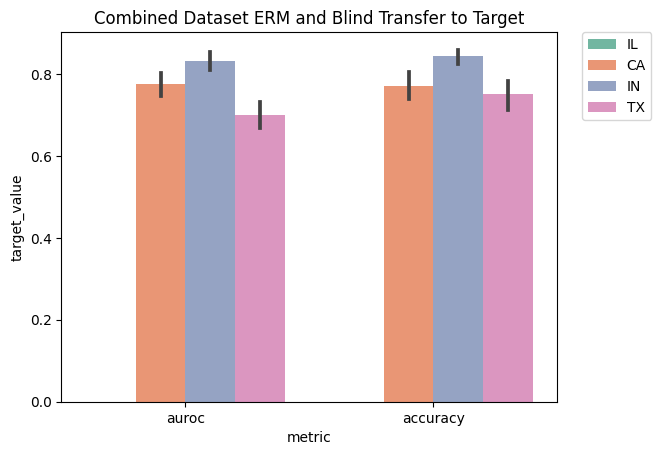

In [445]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='target_state', hue_order=['IL', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Combined Dataset ERM and Blind Transfer to Target');

In [446]:
print_df(summarize_restarts(data))

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,CA,0.877 (0.014),0.867 (0.012),0.804 (0.080),0.770 (0.043),0.775 (0.039),1.587 (0.174),5
1,IL,IN,0.870 (0.008),0.862 (0.010),0.849 (0.111),0.843 (0.022),0.831 (0.029),0.990 (0.053),5
2,IL,TX,0.864 (0.010),0.852 (0.010),0.813 (0.124),0.750 (0.046),0.700 (0.038),1.826 (0.587),5


### ResNet-50 backbone

In [447]:
data = df.loc[(df['backbone'] == 'resnet50') & (df['approach'] == 'Concat_ERM')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet50') & (df_lf['approach'] == 'Concat_ERM')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

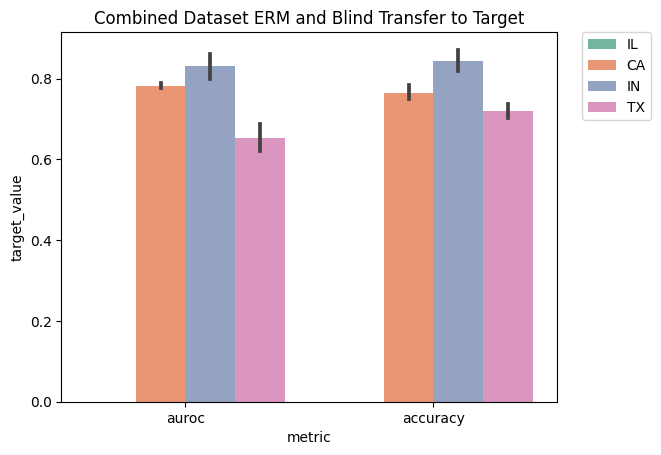

In [448]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='target_state', hue_order=['IL', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Combined Dataset ERM and Blind Transfer to Target');

In [449]:
print_df(summarize_restarts(data))

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,CA,0.856 (0.012),0.843 (0.011),1.211 (0.310),0.764 (0.021),0.783 (0.007),2.207 (0.510),5
1,IL,IN,0.864 (0.011),0.851 (0.011),0.932 (0.162),0.845 (0.034),0.830 (0.040),0.968 (0.321),5
2,IL,TX,0.857 (0.013),0.846 (0.014),1.174 (0.287),0.721 (0.021),0.654 (0.046),3.033 (0.795),5


# Parse Results Files

In [450]:
res_dir = os.path.join(RESULTS_DIR, 'early_stop_auc', 'resnet')

# Get results from child experimental directories
entries = []
incomplete = []
for d in tqdm(os.listdir(res_dir)):
    parsed_d = get_attr_val_from_dirname(d)
    results_count = 0
    for f in os.listdir(os.path.join(res_dir, d)):
        if 'results' in f:
            results = json.load(open(os.path.join(res_dir, d, f), 'rb'))
            results.update(get_src_tgt_metrics(
                results, parsed_d['source_state'], parsed_d['target_state']))
            results.update(parsed_d)
            entries.append(results)
            
            # Add additional entries for in-distribution performance
            if 'fine_tune' not in parsed_d.keys() and parsed_d['source_state'] == 'IL':
                idd_results = copy.deepcopy(results)
                idd_results['test_state'] = results['train_state']
                idd_results['source_state'] = results['train_state']
                idd_results['target_state'] = results['train_state']
                idd_results.update(get_src_tgt_metrics(
                    idd_results, idd_results['source_state'], idd_results['target_state']))
                entries.append(idd_results)
            
            results_count += 1
    # Check that all 5 iterations were completed
    if results_count != 5:
        incomplete.append(d)

  0%|          | 0/182 [00:00<?, ?it/s]

In [451]:
res_dirs = [os.path.join(RESULTS_DIR, 'early_stop_auc', d) for d in [
    'film_block-1_bn-3', 'film_block-2_bn-3', 'film_block-3_bn-3', 'film_block-4_bn-3',
    'film_block-1234_bn-3', 'film_block-1234_bn-123', 'film_block-1234_bn-0123'
]]

# Get FiLM results, parsing parent directory
incomplete = []
for parent_dir in tqdm(res_dirs):
    for d in os.listdir(parent_dir):
        parsed_d = get_attr_val_from_dirname(d)
        parsed_d['block'] = parent_dir.split('/')[-1].split('_')[1].split('-')[-1]
        parsed_d['bn'] = parent_dir.split('/')[-1].split('_')[2].split('-')[-1]
        results_count = 0
        for f in os.listdir(os.path.join(parent_dir, d)):
            if 'results' in f:
                results = json.load(open(os.path.join(parent_dir, d, f), 'rb'))
                results.update(get_src_tgt_metrics(
                    results, parsed_d['source_state'], parsed_d['target_state']))
                results.update(parsed_d)
                entries.append(results)

                # Add additional entries for in-distribution performance
                if 'fine_tune' not in parsed_d.keys() and parsed_d['source_state'] == 'IL':
                    idd_results = copy.deepcopy(results)
                    idd_results['test_state'] = results['train_state']
                    idd_results['source_state'] = results['train_state']
                    idd_results['target_state'] = results['train_state']
                    idd_results.update(get_src_tgt_metrics(
                        idd_results, idd_results['source_state'], idd_results['target_state']))
                    entries.append(idd_results)

                results_count += 1
        # Check that all 5 iterations were completed
        if results_count != 5:
            incomplete.append(d)

  0%|          | 0/7 [00:00<?, ?it/s]

In [452]:
print('Directories with missing results:')
for d in incomplete:
    print('\t', d)

Directories with missing results:
	 resnet152_source-IL_target-TX_ft-block1_ns-all_nt-20
	 resnet152_source-IL_target-TX_ft-block2_ns-all_nt-20
	 resnet152_source-IL_target-TX_ft-block3_ns-all_nt-20
	 resnet152_source-IL_target-TX_ft-block4_ns-all_nt-20
	 resnet152_source-IL_target-TX_ft-all_ns-all_nt-20
	 resnet152_source-IL_target-TX_ft-clf_ns-all_nt-20


In [453]:
state_metric_cols = ['IL_acc', 'IL_auc', 'IL_loss', 'CA_acc', 'CA_auc', 'CA_loss',
               'IN_acc', 'IN_auc', 'IN_loss', 'TX_acc', 'TX_auc', 'TX_loss']
metric_cols = ['source_acc', 'source_auc', 'source_loss', 'target_acc', 'target_auc', 'target_loss']
cols = ['backbone', 'approach', 'domain', 'train_state', 'test_state', 'iter', 'n_samples', 'block', 'bn',
        'source_state', 'target_state', 'fine_tune', 'num_source', 'num_target'] + state_metric_cols + metric_cols

df = pd.DataFrame.from_records(entries, columns=cols).drop(state_metric_cols, axis=1)
df = df.loc[(df['train_state'] != 'NC') & (df['test_state'] != 'NC')]

In [454]:
df['train_state'] = pd.Categorical(
    df['train_state'], 
    categories=['IL'] + sorted([state for state in df.train_state.unique() if state != 'IL']), 
    ordered=True
)
df['test_state'] = pd.Categorical(
    df['test_state'], 
    categories=['IL'] + sorted([state for state in df.test_state.unique() if state != 'IL']), 
    ordered=True
)
df['source_state'] = pd.Categorical(
    df['source_state'], 
    categories=['IL'] + sorted([state for state in df.source_state.unique() if state != 'IL']), 
    ordered=True
)
df['target_state'] = pd.Categorical(
    df['target_state'], 
    categories=['IL'] + sorted([state for state in df.target_state.unique() if state != 'IL']), 
    ordered=True
)

In [455]:
# Create a long-form DataFrame with pivoted metric entries
df_lf = df.copy()
df_lf.loc[:, 'metric'] = df_lf.apply(lambda x: ['accuracy', 'auroc', 'logloss'], axis=1)
df_lf.loc[:, 'source_value'] = df_lf.apply(lambda x: [x.source_acc, x.source_auc, x.source_loss], axis=1)
df_lf.loc[:, 'target_value'] = df_lf.apply(lambda x: [x.target_acc, x.target_auc, x.target_loss], axis=1)

df_lf = df_lf.explode(['metric', 'source_value', 'target_value']).drop(metric_cols, axis=1)

# ResNet Source ERM

### ResNet-152 backbone

In [456]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Source_ERM')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Source_ERM')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

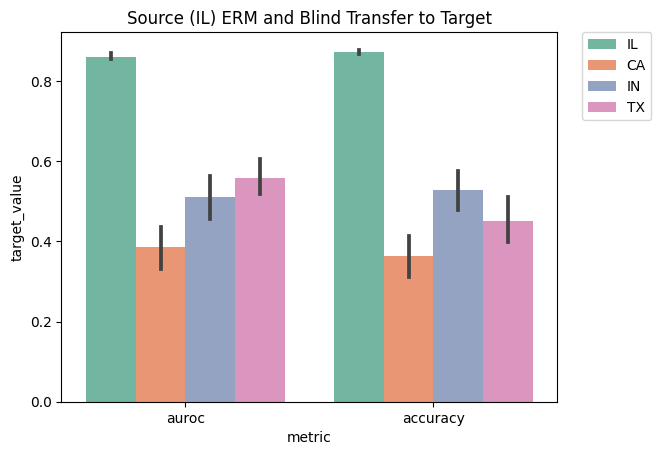

In [457]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='target_state', hue_order=['IL', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM and Blind Transfer to Target');

In [458]:
print_df(summarize_restarts(data))

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,IL,0.872 (0.007),0.861 (0.011),0.918 (0.028),0.872 (0.007),0.861 (0.011),0.918 (0.028),5
1,IL,CA,0.872 (0.007),0.861 (0.011),0.918 (0.028),0.362 (0.067),0.386 (0.066),6.540 (0.821),5
2,IL,IN,0.872 (0.007),0.861 (0.011),0.918 (0.028),0.529 (0.064),0.511 (0.069),4.494 (0.430),5
3,IL,TX,0.872 (0.007),0.861 (0.011),0.918 (0.028),0.451 (0.075),0.558 (0.057),4.784 (1.134),5


### ResNet-50 backbone

In [459]:
data = df.loc[(df['backbone'] == 'resnet50') & (df['approach'] == 'Source_ERM')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet50') & (df_lf['approach'] == 'Source_ERM')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

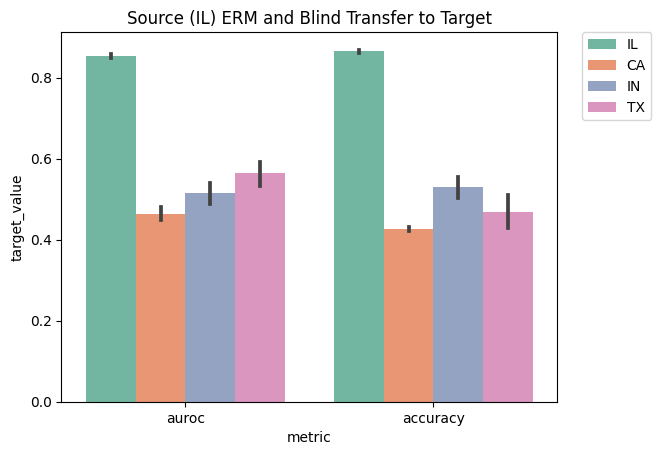

In [460]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='target_state', hue_order=['IL', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM and Blind Transfer to Target');

In [461]:
print_df(summarize_restarts(data))

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,IL,0.865 (0.006),0.854 (0.007),0.801 (0.073),0.865 (0.006),0.854 (0.007),0.801 (0.073),5
1,IL,CA,0.865 (0.006),0.854 (0.007),0.801 (0.073),0.427 (0.007),0.462 (0.022),4.910 (0.756),5
2,IL,IN,0.865 (0.006),0.854 (0.007),0.801 (0.073),0.530 (0.033),0.515 (0.035),3.371 (0.365),5
3,IL,TX,0.865 (0.006),0.854 (0.007),0.801 (0.073),0.469 (0.055),0.564 (0.039),4.010 (0.595),5


# Fine-Tune ResNet

### ResNet-152 backbone

In [483]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Fine_Tune')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Fine_Tune')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

# Concatenate source ERM entries
source_erm = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Source_ERM')].drop_duplicates(ignore_index=True)
source_erm = source_erm.sort_values('target_state').reset_index(drop=True)
source_erm.loc[:, 'fine_tune'] = 'all'
source_erm.loc[:, 'n_samples'] = 0
data = pd.concat([data, source_erm], axis=0)

source_erm_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Source_ERM')].drop_duplicates(ignore_index=True)
source_erm_lf = source_erm_lf.sort_values('target_state').reset_index(drop=True)
source_erm_lf.loc[:, 'fine_tune'] = 'all'
source_erm_lf.loc[:, 'n_samples'] = 0
data_lf = pd.concat([data_lf, source_erm_lf], axis=0)

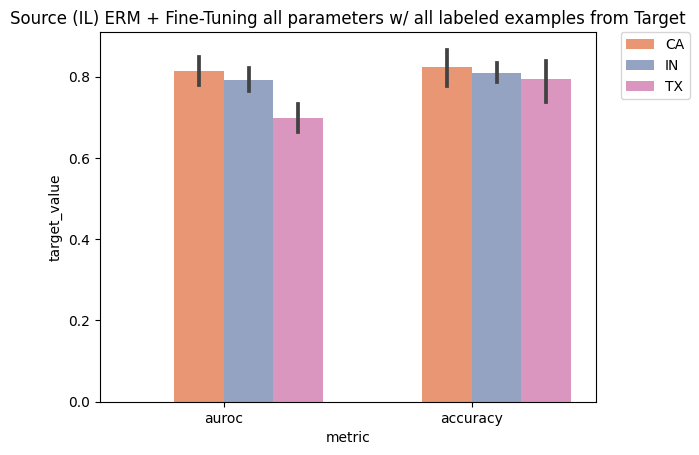

In [484]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss') & (data_lf['n_samples'] == -1) & (data_lf['fine_tune'] == 'all')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='target_state', hue_order=['', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM + Fine-Tuning all parameters w/ all labeled examples from Target');

In [485]:
print_df(summarize_restarts(data.loc[(data['n_samples'] == -1) & (data['fine_tune'] == 'all')]))

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,CA,0.770 (0.027),0.780 (0.016),1.134 (0.537),0.823 (0.061),0.813 (0.045),0.687 (0.202),5
1,IL,IN,0.835 (0.012),0.817 (0.011),0.608 (0.063),0.809 (0.033),0.791 (0.038),0.631 (0.090),5
2,IL,TX,0.760 (0.081),0.785 (0.056),1.717 (0.622),0.794 (0.067),0.698 (0.046),1.834 (0.956),5


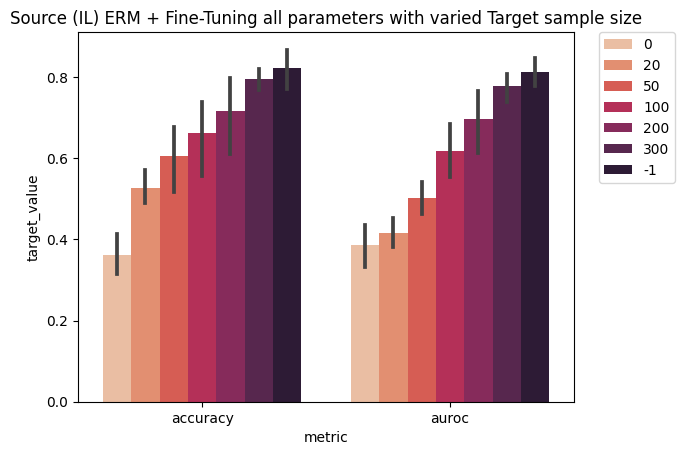

In [486]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss') & (data_lf['target_state'] == 'CA') & (data_lf['fine_tune'] == 'all')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='n_samples', hue_order=[0, 20, 50, 100, 200, 300, -1], palette='rocket_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM + Fine-Tuning all parameters with varied Target sample size');

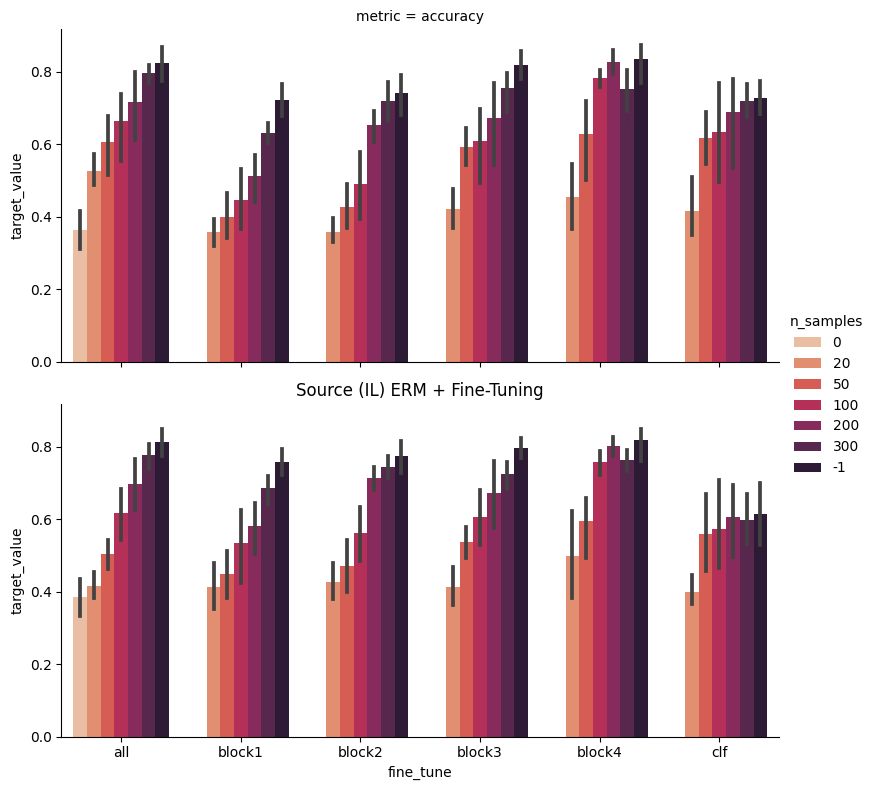

In [466]:
sns.catplot(data=data_lf.loc[(data_lf['metric'] != 'logloss') & (data_lf['target_state'] == 'CA')].drop_duplicates(ignore_index=True),
            x='fine_tune', order=['all', 'block1', 'block2', 'block3', 'block4', 'clf'],
            y='target_value', hue='n_samples', hue_order=[0, 20, 50, 100, 200, 300, -1], 
            row='metric', kind='bar', palette='rocket_r',
            height=4, aspect=2)
plt.title('Source (IL) ERM + Fine-Tuning');

In [467]:
print_df(summarize_restarts(data.loc[data['target_state'] == 'CA'], groupby_cols=['source_state', 'target_state', 'fine_tune', 'n_samples']))

,source_state,target_state,fine_tune,n_samples,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,CA,all,-1,0.770 (0.027),0.780 (0.016),1.134 (0.537),0.823 (0.061),0.813 (0.045),0.687 (0.202),5
1,IL,CA,all,0,0.872 (0.007),0.861 (0.011),0.918 (0.028),0.362 (0.067),0.386 (0.066),6.540 (0.821),5
2,IL,CA,all,20,0.719 (0.092),0.761 (0.071),8.546 (8.762),0.527 (0.051),0.416 (0.045),8.336 (2.163),5
3,IL,CA,all,50,0.639 (0.136),0.698 (0.098),30.072 (60.628),0.605 (0.105),0.503 (0.050),12.001 (19.564),5
4,IL,CA,all,100,0.757 (0.069),0.784 (0.048),2.294 (1.188),0.662 (0.122),0.618 (0.089),2.908 (1.856),5
5,IL,CA,all,200,0.806 (0.037),0.816 (0.023),1.211 (0.246),0.716 (0.129),0.698 (0.096),2.105 (1.238),5
6,IL,CA,all,300,0.784 (0.018),0.797 (0.009),1.149 (0.379),0.796 (0.035),0.778 (0.045),1.248 (0.476),5
7,IL,CA,block1,-1,0.776 (0.019),0.737 (0.030),2.046 (0.275),0.723 (0.060),0.758 (0.048),2.305 (0.841),5
8,IL,CA,block1,20,0.800 (0.092),0.773 (0.114),210.636 (451.430),0.357 (0.046),0.412 (0.084),345.145 (750.280),5
9,IL,CA,block1,50,0.835 (0.041),0.818 (0.031),4.414 (6.354),0.400 (0.082),0.448 (0.086),8.338 (2.439),5


# ResNet Target ERM

In [468]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Target_ERM')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Target_ERM')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

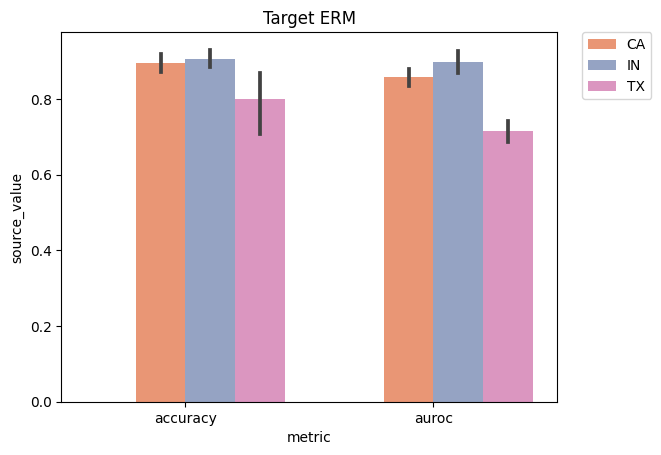

In [469]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='source_value', hue='train_state', hue_order=['', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Target ERM');

In [470]:
print_df(summarize_restarts(data), metric_prefix='source')

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,CA,IL,0.895 (0.031),0.858 (0.028),0.388 (0.180),0.555 (0.026),0.510 (0.012),1.819 (0.671),5
1,IN,IL,0.907 (0.030),0.897 (0.039),0.276 (0.068),0.539 (0.023),0.509 (0.011),1.674 (0.460),5
2,TX,IL,0.800 (0.106),0.716 (0.035),0.757 (0.221),0.562 (0.027),0.502 (0.006),2.110 (0.462),5


# FiLM Source ERM

### ResNet-152 backbone

In [471]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'FiLM_Source_ERM') & (df['block'] == '1234') & (df['bn'] == '3')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'FiLM_Source_ERM') & (df['block'] == '1234') & (df['bn'] == '3')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

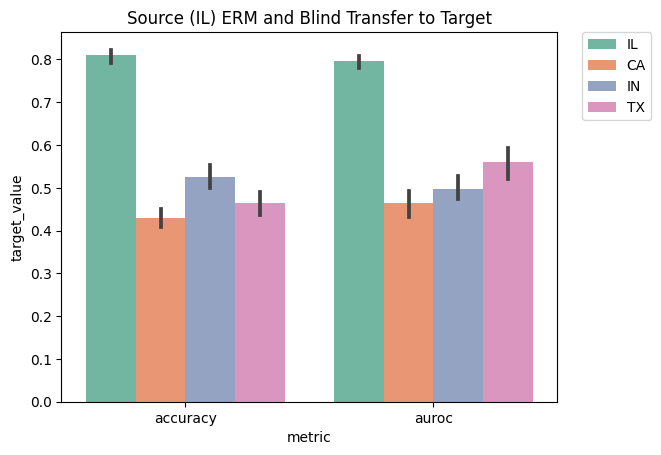

In [472]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='target_state', hue_order=['IL', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM and Blind Transfer to Target');

In [473]:
print_df(summarize_restarts(data))

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,IL,0.809 (0.021),0.795 (0.018),1.386 (0.201),0.809 (0.021),0.795 (0.018),1.386 (0.201),5
1,IL,CA,0.809 (0.021),0.795 (0.018),1.386 (0.201),0.429 (0.026),0.464 (0.035),5.921 (0.685),5
2,IL,IN,0.809 (0.021),0.795 (0.018),1.386 (0.201),0.525 (0.038),0.496 (0.036),4.421 (0.397),5
3,IL,TX,0.809 (0.021),0.795 (0.018),1.386 (0.201),0.465 (0.034),0.561 (0.046),4.560 (0.819),5


# Fine-Tune FiLM

### ResNet-152 backbone

In [474]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'FiLM_Fine_Tune') & (df['block'] == '1234') & (df['bn'] == '3')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'FiLM_Fine_Tune') & (df_lf['block'] == '1234') & (df_lf['bn'] == '3')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

# Concatenate source ERM entries
source_erm = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'FiLM_Source_ERM')].drop_duplicates(ignore_index=True)
source_erm = source_erm.sort_values('target_state').reset_index(drop=True)
source_erm.loc[:, 'fine_tune'] = 'all'
source_erm.loc[:, 'n_samples'] = 0
data = pd.concat([data, source_erm], axis=0)

source_erm_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'FiLM_Source_ERM')].drop_duplicates(ignore_index=True)
source_erm_lf = source_erm_lf.sort_values('target_state').reset_index(drop=True)
source_erm_lf.loc[:, 'fine_tune'] = 'all'
source_erm_lf.loc[:, 'n_samples'] = 0
data_lf = pd.concat([data_lf, source_erm_lf], axis=0)

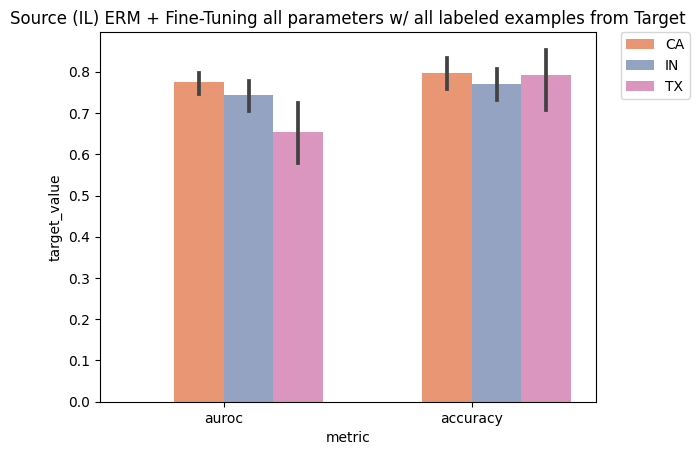

In [475]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss') & (data_lf['n_samples'] == -1) & (data_lf['fine_tune'] == 'all')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='target_state', hue_order=['', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM + Fine-Tuning all parameters w/ all labeled examples from Target');

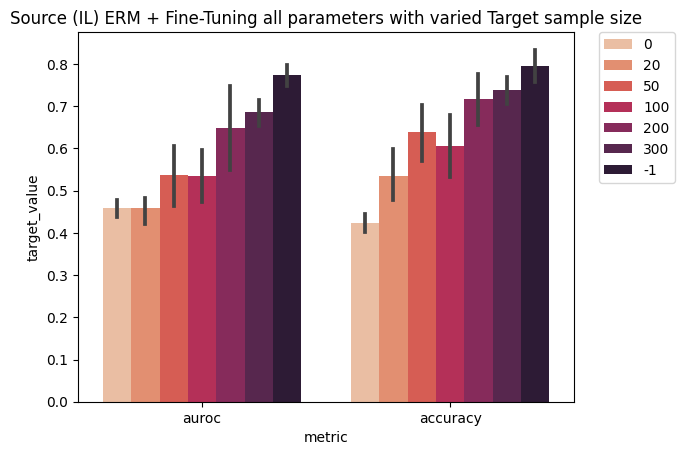

In [476]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss') & (data_lf['target_state'] == 'CA') & (data_lf['fine_tune'] == 'all')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='n_samples', hue_order=[0, 20, 50, 100, 200, 300, -1], palette='rocket_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM + Fine-Tuning all parameters with varied Target sample size');

In [477]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'FiLM_Fine_Tune') & (df['block'].isin(['1', '2', '3', '4', '1234'])) & (df['bn'] == '3')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'FiLM_Fine_Tune') & (df['block'].isin(['1', '2', '3', '4', '1234'])) & (df_lf['bn'] == '3')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

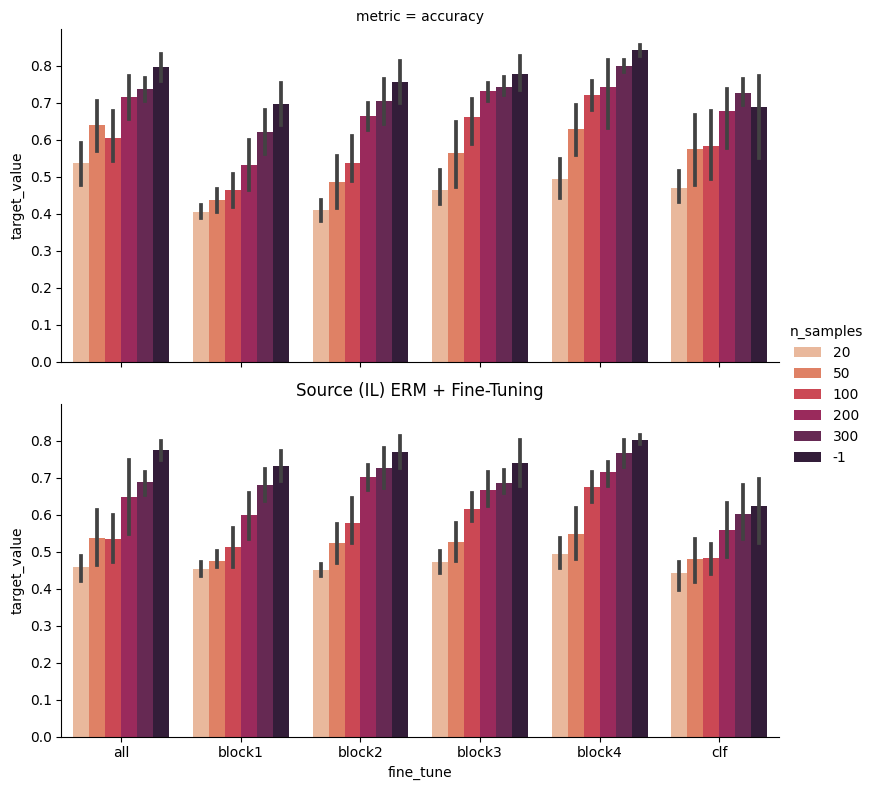

In [478]:
sns.catplot(data=data_lf.loc[(data_lf['metric'] != 'logloss') & (data_lf['target_state'] == 'CA')].drop_duplicates(ignore_index=True),
            x='fine_tune', order=['all', 'block1', 'block2', 'block3', 'block4', 'clf'],
            y='target_value', hue='n_samples', hue_order=[20, 50, 100, 200, 300, -1], 
            row='metric', kind='bar', palette='rocket_r',
            height=4, aspect=2)
plt.title('Source (IL) ERM + Fine-Tuning');

In [479]:
print_df(summarize_restarts(data.loc[data['target_state'] == 'CA'], groupby_cols=['source_state', 'target_state', 'fine_tune', 'n_samples']))

,source_state,target_state,fine_tune,n_samples,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,CA,all,-1,0.704 (0.038),0.716 (0.033),1.338 (0.375),0.796 (0.047),0.774 (0.033),1.123 (0.674),5
1,IL,CA,all,20,0.689 (0.097),0.731 (0.067),3.008 (1.434),0.536 (0.077),0.459 (0.042),5.724 (1.524),5
2,IL,CA,all,50,0.664 (0.053),0.715 (0.038),2.682 (0.802),0.639 (0.083),0.537 (0.093),3.536 (1.318),5
3,IL,CA,all,100,0.672 (0.133),0.712 (0.087),2.870 (1.958),0.605 (0.092),0.534 (0.078),3.874 (1.601),5
4,IL,CA,all,200,0.668 (0.092),0.708 (0.058),2.526 (1.892),0.716 (0.079),0.648 (0.130),2.327 (1.553),5
5,IL,CA,all,300,0.688 (0.027),0.720 (0.022),1.595 (0.207),0.737 (0.041),0.687 (0.040),1.340 (0.378),5
6,IL,CA,block1,-1,0.744 (0.012),0.706 (0.027),2.354 (0.447),0.696 (0.075),0.732 (0.052),2.448 (0.915),5
7,IL,CA,block1,20,0.853 (0.014),0.835 (0.020),1.293 (0.177),0.405 (0.023),0.452 (0.023),8.810 (2.379),5
8,IL,CA,block1,50,0.857 (0.013),0.845 (0.021),1.173 (0.229),0.436 (0.043),0.475 (0.027),7.574 (1.768),5
9,IL,CA,block1,100,0.848 (0.028),0.829 (0.042),1.246 (0.143),0.463 (0.062),0.511 (0.068),6.673 (1.840),5


# FiLM Target ERM

In [480]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'FiLM_Target_ERM') & (df['block'] == '1234') & (df['bn'] == '3')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'FiLM_Target_ERM') & (df['block'] == '1234') & (df['bn'] == '3')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

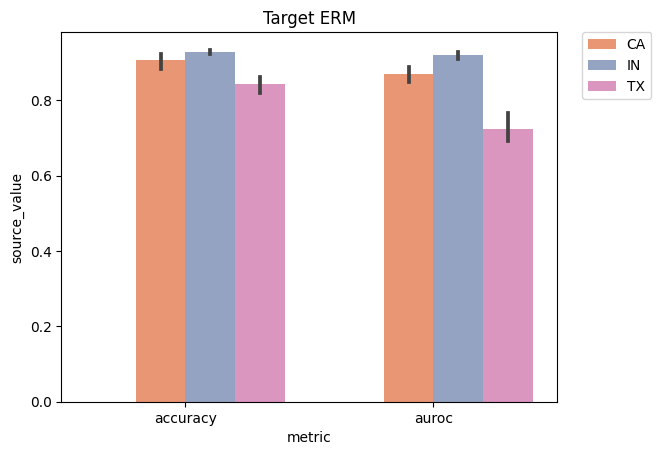

In [481]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='source_value', hue='train_state', hue_order=['', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Target ERM');

In [482]:
print_df(summarize_restarts(data), metric_prefix='source')

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,CA,IL,0.907 (0.025),0.869 (0.027),0.299 (0.052),0.552 (0.022),0.504 (0.007),1.702 (0.620),5
1,IN,IL,0.929 (0.006),0.921 (0.013),0.207 (0.035),0.548 (0.002),0.506 (0.012),1.533 (0.152),5
2,TX,IL,0.844 (0.027),0.723 (0.048),0.691 (0.061),0.522 (0.036),0.502 (0.007),2.335 (0.490),5
